Once you know to use grid search cv go back to knn notebook to finish second task

## Logistic regression

Another strong baseline to evaluate is logistic regression
- Evaluate a logistic regression model (without any hyperparameters tuning)
- Tune its regularization strength parameter with cross-validated grid-search and compare the accuracy to the untuned one
- Pick ten images and compute the probability for each class using the predict_proba() function of your estimator. Plot the results for each image and comment your findings. For example, you can plot the ten images in subplots and collect the probabilities in a DataFrame.
- Finally, vary the regularization strength of your estimator. What is the effect on the probabilities? Write your observations in a markdown cell.

In [1]:
import numpy as np
import pandas as pd

In [2]:
with np.load('train.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    x_train = npz_file['features']
    y_train = npz_file['targets']

with np.load('valid.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    x_valid = npz_file['features']
    y_valid = npz_file['targets']

with np.load('test.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    x_test = npz_file['features']
    y_test = npz_file['targets']

# X = np.concatenate((x_train, x_valid, x_test), axis=0)
# y = np.concatenate((y_train, y_valid, y_test), axis=0)

Again, the data has already been standardized during the feature extraction process.It's possible to standardize the data with TensorFlow, but especially in the case of images, this might not be what you want. Dividing by 255 should be enough to do the necessary preprocessing here.

---------

- Evaluate a logistic regression model (without any hyperparameters tuning)


Let's try a multiclass logistic regression with OvR:

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [4]:
# Create the estimator
logreg = make_pipeline(
    LogisticRegression(multi_class='ovr', solver='liblinear')) # using the liblinear one for small data sets.

In [5]:
# Fit it to train data
logreg.fit(x_train, y_train)

# Accuracy on test set
accuracy = logreg.score(x_valid, y_valid)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.137


Let's try a multinomial logistic regression (also known as softmax regression), by setting the multi_class parameter to multinomial. The solver Liblinear doesn't support the softmax variant - change to Saga and set a max_iter to avoid convergence issues:

In [6]:
# Create the estimator
logreg = make_pipeline(
    LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000))

# Fit it to train data
logreg.fit(x_train, y_train)

# Accuracy on test set
accuracy = logreg.score(x_valid, y_valid)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.137


We obtain an accuracy of roughly 14%. The accuracy is rather low since no hypertuning has taken place. We can fight overfitting with hyperparameters tuning.

----------

- Tune its regularization strength parameter with cross-validated grid-search and compare the accuracy to the untuned one

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV 
import numpy as np

In [8]:
# Create pipeline
pipe = Pipeline([
    ('logreg', LogisticRegression(multi_class='ovr', solver='liblinear'))
])

We pass ten C values (which is the inverse of regularization term) on a log scale between 10^(-4) and 10^4 and set the cv strategy to 5-fold cross-validation (stratified by default for classification tasks):

In [9]:
# Create cross-validation object
grid = {
    'logreg__C': np.logspace(-4, 4, num=10)
}
grid_cv = GridSearchCV(pipe, grid, cv=5, return_train_score=True)

Merge the validation and training sets; the cross-validated splits in addition to the final retrain
will be done automatically by GridSearchCV.

In [10]:
# Fit estimator
grid_cv.fit(np.concatenate((x_train, x_valid), axis=0), np.concatenate((y_train, y_valid), axis=0))

# Get the results with "cv_results_"
grid_cv.cv_results_.keys()

C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logreg__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [11]:
# Standard deviation of test scores
grid_cv.cv_results_['mean_test_score']

array([0.3150358 , 0.3699284 , 0.39140811, 0.3221957 , 0.28400955,
       0.27923628, 0.27684964, 0.2601432 , 0.2601432 , 0.25298329])

According to the mean test score a low C parameter (= high regularization strengths) has the best test accuracy. The cross-validated grid-search yields a higher accuracy for some parameters and for some even a lower accuracy compared to the untuned one. Overall we can say that regularization could be helpful.

In [12]:
import pandas as pd

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_cv.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_logreg__C']
cv_results[cols].sort_values('mean_test_score', ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logreg__C
2,0.391408,0.194680,0.645047,0.014536,0.00599484
1,0.369928,0.167814,0.485387,0.049374,0.000774264
3,0.322196,0.121435,0.959989,0.008076,0.0464159
0,0.315036,0.110428,0.388144,0.055780,0.0001
4,0.284010,0.106474,0.998212,0.001460,0.359381
5,0.279236,0.097767,1.000000,0.000000,2.78256
6,0.276850,0.103397,1.000000,0.000000,21.5443
7,0.260143,0.090193,1.000000,0.000000,166.81
8,0.260143,0.090193,1.000000,0.000000,1291.55
9,0.252983,0.099161,1.000000,0.000000,10000


We obtain a train accuracy of 1 for higher C values which means that our estimator correctly classified all points from the train set. However this is a sign of overfitting and is resulting in an increased generalization error (hence lower test score).

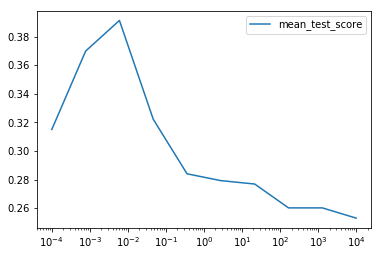

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot test curve
plt.semilogx(cv_results['param_logreg__C'], cv_results['mean_test_score'])
plt.legend()
plt.show()

----------

- Pick ten images and compute the probability for each class using the predict_proba() function of your estimator. Plot the results for each image and comment your findings. For example, you can plot the ten images in subplots and collect the probabilities in a DataFrame.

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
test_generator = ImageDataGenerator(rescale=1/255)

In [16]:
testset = test_generator.flow_from_directory(
     'test', batch_size=3, target_size=(224, 224))

Found 50 images belonging to 6 classes.


In [17]:
d = np.round(grid_cv.predict_proba(x_test)[0:20:2],3)

In [18]:
df = pd.DataFrame(d, index=testset.filenames[0:20:2],  columns=('bike','car','motorcycle','other','truck','van'))

In [19]:
import PIL.Image as Image

In [20]:
img_set = []

for i in np.arange(0,20,2):
    img = Image.open('test\\' + testset.filenames[i])
    img_set.append(img)

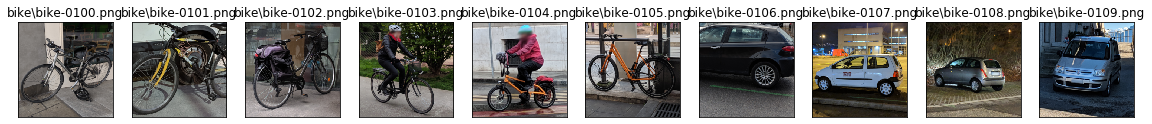

,bike,car,motorcycle,other,truck,van
bike\bike-0100.png,0.510,0.140,0.063,0.079,0.088,0.120
bike\bike-0102.png,0.657,0.099,0.064,0.053,0.055,0.072
bike\bike-0104.png,0.488,0.157,0.125,0.074,0.056,0.100
bike\bike-0106.png,0.562,0.091,0.146,0.059,0.052,0.090
bike\bike-0108.png,0.432,0.172,0.186,0.054,0.061,0.096
bike\bike-0110.png,0.505,0.105,0.088,0.077,0.078,0.146
car\car-0097.png,0.092,0.449,0.143,0.068,0.092,0.157
car\car-0099.png,0.078,0.431,0.101,0.079,0.104,0.207
car\car-0101.png,0.110,0.525,0.111,0.052,0.129,0.073
car\car-0103.png,0.116,0.269,0.218,0.108,0.178,0.111


In [21]:
# Create figure with 10 subplots
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 10))

# Plot the weights for each class in a subplot
for i, axis in enumerate(axes):
            
    # contain each axis and its index in the list of axes
    # img = Image.open('test\\' + testset.filenames[i])

    # Plot array
    axis.imshow(img_set[i]) # Grayscale (reversed)
    axis.set_title(testset.filenames[i])
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis

plt.show()
df

The highest value per row determines the estimated picture due to the highest probability. This is why the estimator predicts 0 respectively 'bikes' for the first 6 images and the remaining 1 respectively 'cars' in the x_test set. We can double check that the predict_proba has correctly identified the respective class with the predict() function:

In [22]:
# Compute predictions with the "best_estimator_" attribute
grid_cv.best_estimator_.predict(x_test)[0:20:2]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

--------------

- Finally, vary the regularization strength of your estimator. What is the effect on the probabilities? Write your observations in a markdown cell.

In [23]:
d_1 = []

for i in [1, 0.1, 0.01, 0.001]:
    grid = {'logreg__C': [i]}
    
    grid_cv = GridSearchCV(pipe, grid, cv=5, return_train_score=True)
    grid_cv.fit(np.concatenate((x_train, x_valid), axis=0), np.concatenate((y_train, y_valid), axis=0))
    
    d_i = np.round(grid_cv.predict_proba(x_test)[0],3)
    d_1.append(d_i)

df_1 = pd.DataFrame(d_1, index = [1, 0.1, 0.01, 0.001], columns=('bike','car','motorcycle','other','truck','van'))

C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages

In [24]:
d_2 = []

for i in [1, 10, 100, 1000]:
    grid = {'logreg__C': [i]}
    
    grid_cv = GridSearchCV(pipe, grid, cv=5, return_train_score=True)
    grid_cv.fit(np.concatenate((x_train, x_valid), axis=0), np.concatenate((y_train, y_valid), axis=0))
    
    d_i = np.round(grid_cv.predict_proba(x_test)[0],3)
    d_2.append(d_i)

df_2 = pd.DataFrame(d_2, index = [1, 10, 100, 1000], columns=('bike','car','motorcycle','other','truck','van'))

C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\heyus\anaconda3\envs\exts-ml\lib\site-packages

In [25]:
print(df_1)
print(df_2)

        bike    car  motorcycle  other  truck    van
1.000  0.810  0.132       0.000  0.002  0.012  0.043
0.100  0.679  0.146       0.008  0.025  0.042  0.100
0.010  0.539  0.138       0.050  0.072  0.080  0.121
0.001  0.389  0.156       0.113  0.106  0.117  0.121
       bike    car  motorcycle  other  truck    van
1     0.810  0.132         0.0  0.002  0.012  0.043
10    0.887  0.097         0.0  0.000  0.002  0.013
100   0.933  0.062         0.0  0.000  0.000  0.004
1000  0.962  0.037         0.0  0.000  0.000  0.001


**Observations:** the regularization strength C of my estimator has been varied between 0.001 and 1000 while all other parameters are fixed. Afterwards the predicted probabilites have been calculated for the same image (a bike) in the test data set. We can clearly see a positive relationship, that is a high number of C results in a higher predicted probability for the class 'bike'.

-----------

Store the model name and the accuracy on the test data in a .csv file:

In [28]:
grid_cv.score(x_test, y_test)

0.64

In [30]:
Test_accuracy_05_Logistic_regression_baseline =  pd.DataFrame(data = {'model': ['logistic'], 'test_acurracy': [grid_cv.score(x_test, y_test)]})

In [32]:
Test_accuracy_05_Logistic_regression_baseline.to_csv(path_or_buf = r'C:\Users\heyus\Desktop\Desktop\EPFL_Data Science COS\EPFL\04. Applied Machine Learning 2\11. Course project\Test_accuracy_05_Logistic_regression_baseline.csv')